In [11]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import io
import seaborn as sns

In [12]:
import requests
url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
raw_data=requests.get(url).content


In [13]:


corona_data = pd.read_csv(io.StringIO(raw_data.decode('utf-8')))
#print(corona_data.columns)
corona_data.head(10)
first_data_col = corona_data.columns.to_list().index("1/22/20")
print(f"1st data column : {first_data_col}")
assert first_data_col>2

1st data column : 4


In [14]:
countries = corona_data['Country/Region']
provinces = corona_data['Province/State']
curr_cases = corona_data[corona_data.columns[-1]]
limit = 5000

geos = { c+("/"+str(p) if p is not np.nan else "") :(i,c,(str(p) if p is not np.nan else ""),s) for c,p,s,i in zip(countries,provinces,curr_cases,range(len(countries))) if s>=limit}
print(f"Total {len(geos)} geo locations with current caeses count > {limit}") 
print(list(k+str(v) for k,v in geos.items()))


Total 8 geo locations with current caeses count > 5000
["Germany(11, 'Germany', '', 15320)", "Italy(16, 'Italy', '', 41035)", "Spain(18, 'Spain', '', 17963)", "US/New York(99, 'US', 'New York', 5365)", "China/Hubei(154, 'China', 'Hubei', 67800)", "Iran(155, 'Iran', '', 18407)", "Korea, South(156, 'Korea, South', '', 8565)", "France/France(157, 'France', 'France', 10871)"]


In [15]:
 def get_series(i):
        fr =  corona_data.iloc[i,first_data_col:]
        return np.array([f for f in fr if f>100 ])

dict_keys(['Germany', 'Italy', 'Spain', 'US/New York', 'Iran', 'Korea, South', 'France/France'])
Max days 29


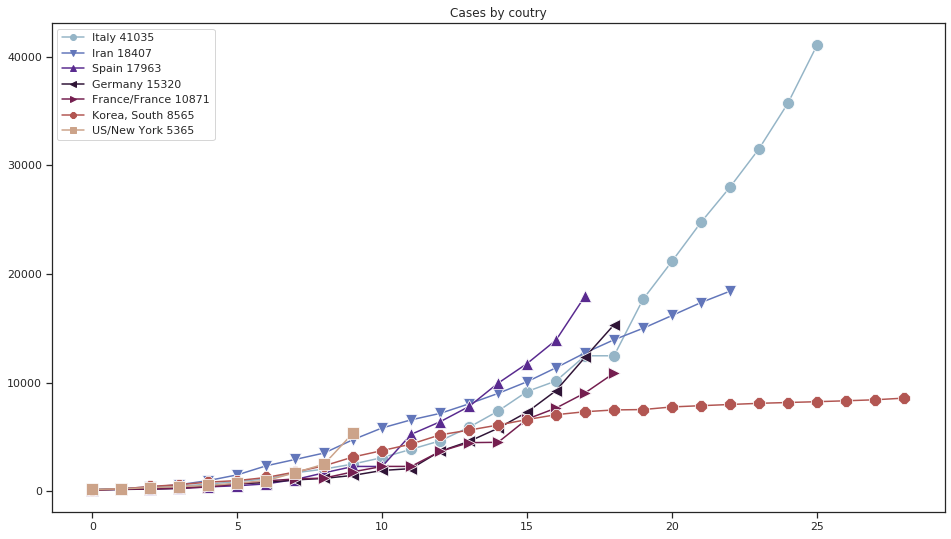

In [16]:
from functools import reduce
skip_china = True
series = { c : get_series(geos[c][0]) for c in geos.keys() if (not skip_china or not c.startswith("China")) }

print(series.keys())
max_days = reduce(max,map(len,series.values()))
print (f"Max days {max_days}")
sns.set(style="ticks")

data = data = pd.DataFrame ()

sorted_keys = list(series.keys())
sorted_keys.sort(key = lambda a: -series[a][-1])

for c in sorted_keys:
    data = pd.concat([data,pd.DataFrame ({f"{c} {series[c][-1]}":get_series(geos[c][0])})],axis=1)
  
plt.figure(figsize=(16, 9))
plt.title("Cases by country")
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
sns.lineplot(data = data, palette="twilight", hue="label",linewidth=1.5, dashes = False,style= True, markers = filled_markers, markersize=12)


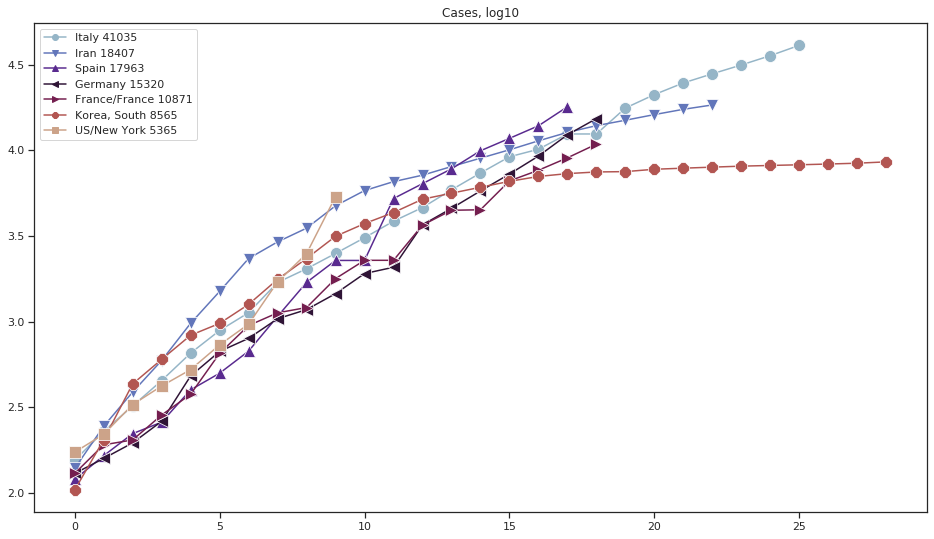

In [17]:
from math import log10
plt.figure(figsize=(16, 9))
plt.title("Cases, log10")

sns.lineplot(data = data.applymap(log10), palette="twilight", hue="label",linewidth=1.5, dashes = False,style= True, markers = filled_markers, markersize=12)

